In [1]:
from math import ceil
import sys
from matplotlib.axes import Axes
from matplotlib.colors import Normalize
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from pathlib import Path
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

current_folder = globals()['_dh'][0]
sys.path.append(str(Path(current_folder,'..').resolve()))

from CustomEnvs.Indexes import OBS_INDEX
from CustomEnvs.CarParking import calculate_reward
from PostProcessing.Utils import MAP_BOUNDARY
import MJCFGenerator.Config as mjcf_cfg
import PathsConfig as paths_cfg

pygame 2.5.2 (SDL 2.28.3, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Reward Function

In [10]:
def visualize_reward_function(reward_params):
    parking_point = np.array(mjcf_cfg.PARKING_SPOT_KWARGS['pos'][:2])
    
    x_values = np.linspace(MAP_BOUNDARY[0][0], MAP_BOUNDARY[0][1], 50)
    y_values = np.linspace(MAP_BOUNDARY[0][0], MAP_BOUNDARY[0][1], 50)
            
    mesh = np.meshgrid(x_values, y_values)
    XY = np.vstack([mesh[0].ravel(),mesh[1].ravel()]).T
    
    observation = np.zeros(OBS_INDEX.OBS_SIZE, dtype=np.float32)
    angles = np.linspace(0, len(observation[OBS_INDEX.ANGLE_DIFF_BEGIN:OBS_INDEX.ANGLE_DIFF_END+1])*math.pi, 4)
    
    
    axs_2d:list[list[Axes]]
    fig_2d:Figure
    car_spawn_kwargs = mjcf_cfg.CAR_SPAWN_KWARGS[:3]
    
    
    fig_2d, axs_2d = plt.subplots(len(car_spawn_kwargs), len(angles), figsize=(10,8))
    fig_3d, axs_3d = plt.subplots(len(car_spawn_kwargs), len(angles), figsize=(10,8), subplot_kw={'projection': '3d'})
    
    norm = Normalize(vmin=0, vmax=reward_params['max_step_reward'])
    
    for i, spawn_kwargs in enumerate(car_spawn_kwargs):
        spawn_point = np.array(spawn_kwargs['pos'][:2])
        init_car_distance = np.linalg.norm(spawn_point - parking_point)
        for j, angle in enumerate(angles):
            
            observation[OBS_INDEX.ANGLE_DIFF_BEGIN:OBS_INDEX.ANGLE_DIFF_END+1] = angle/2, angle/2
            
            rewards = []
            for xy in XY:
                car_dist_to_parking = np.linalg.norm(xy - parking_point)
                
                observation[OBS_INDEX.DISTANCE_BEGIN:OBS_INDEX.DISTANCE_END+1] = car_dist_to_parking
                reward, reward_info = calculate_reward(observation, init_car_distance, reward_params)
                # print(reward)
                rewards.append(reward)
            
            observation[OBS_INDEX.DISTANCE_BEGIN:OBS_INDEX.DISTANCE_END+1] = np.linalg.norm(spawn_point - parking_point)
            spawn_reward, _ = calculate_reward(observation, init_car_distance, reward_params)
            
            rewards = np.array(rewards).reshape(mesh[0].shape)
            
            im = axs_2d[i, j].pcolormesh(mesh[0], mesh[1], rewards, shading='auto', norm=norm)
            axs_2d[i, j].scatter(*spawn_point, color="red", s=25)
            axs_2d[i, j].set_title(f'{angle:.2f}')
            axs_2d[i, j].set_aspect('equal')
            
            
            surf = axs_3d[i,j].plot_surface(mesh[0], mesh[1], rewards, cmap=cm.viridis, norm=norm)
            axs_3d[i, j].scatter(*spawn_point, spawn_reward, color="red", s=25)
            axs_3d[i, j].set_title(f'{angle:.2f}')
            axs_3d[i, j].set_zlim((0, reward_params['max_step_reward']))
            # axs_3d[i, j].view_init(elev=30)
            
    title = ", ".join([ f"{key}={val}" for key, val in reward_params.items()])
    fig_2d.suptitle(title)
    fig_3d.suptitle(title)
    
    colorbar_ax = fig_2d.add_axes([0.1, 0.05, 0.8, 0.02])
    cbar = fig_2d.colorbar(im, cax=colorbar_ax, orientation='horizontal')
    cbar.set_label('Reward Value')
    
    fig_2d.subplots_adjust(left=0.1, right=0.9, top=0.90, bottom=0.1)
    fig_2d.savefig(str(Path(paths_cfg.OUT_LEARNING_DIR,"reward_function_2d.png")))
    fig_3d.savefig(str(Path(paths_cfg.OUT_LEARNING_DIR,"reward_function_3d.png")))


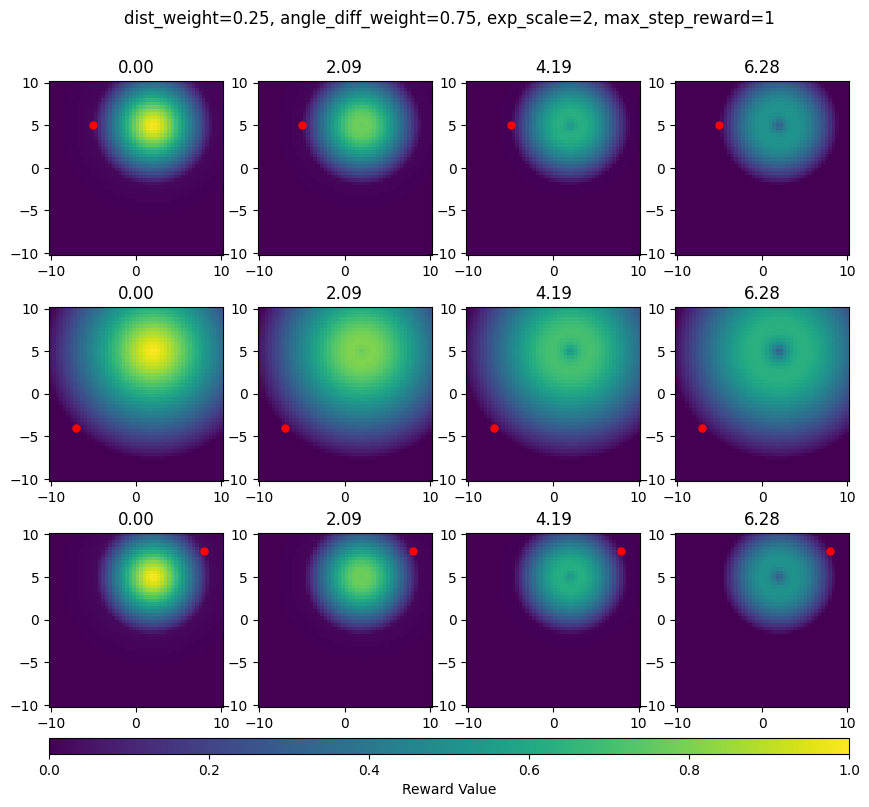

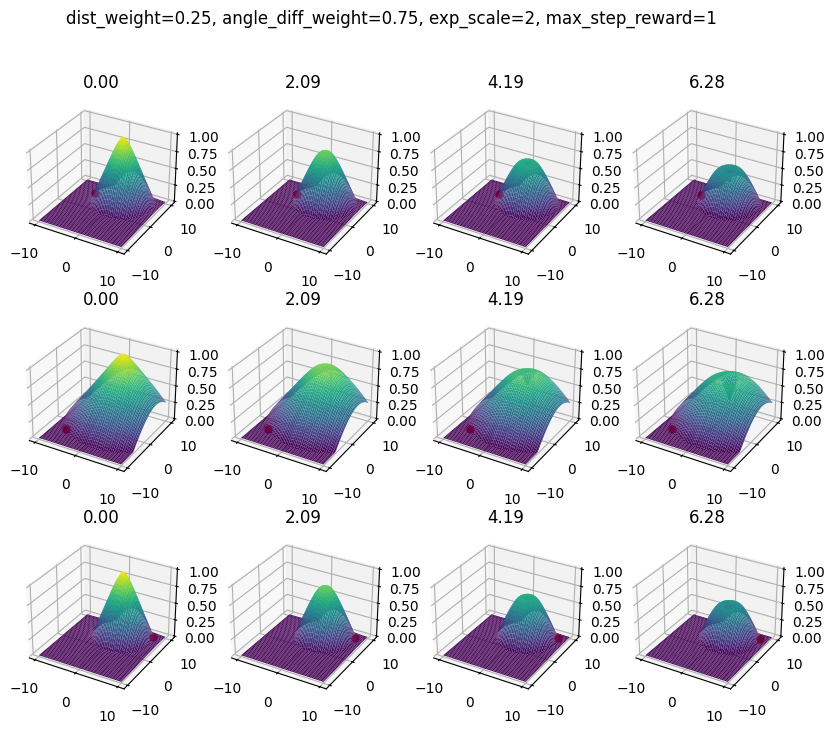

In [11]:
visualize_reward_function(
        {
            "dist_weight": 0.25,
            "angle_diff_weight": 0.75,
            "exp_scale":2,
            "max_step_reward": 1
        })